# Part 1 - Train model

In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from PIL import Image as ImagePIL
from IPython.display import display


Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# Make tensorflow dataset.
image_size = (256,256)
batch_size = 1

image_path = "./data/"

train = keras.preprocessing.image_dataset_from_directory(
    image_path,
    labels=None,
    image_size=image_size,
    batch_size=batch_size
)

Found 4 files belonging to 1 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-06 15:00:56.876686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-06 15:00:56.876917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Model
def get_model():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")   
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), activation="relu", padding='same', name="Conv1")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv2")(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv2")(x) 
    outputs = activations.tanh(x)   
    return keras.Model(inputs=inputs, outputs=outputs, name="fcn_model")

model = get_model()
model.summary()

Model: "fcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 256, 256, 32)      7808      
_________________________________________________________________
Conv2 (Conv2D)               (None, 128, 128, 64)      18496     
_________________________________________________________________
Deconv1 (Conv2DTranspose)    (None, 256, 256, 32)      18464     
_________________________________________________________________
Deconv2 (Conv2DTranspose)    (None, 256, 256, 3)       7779      
_________________________________________________________________
tf.math.tanh (TFOpLambda)    (None, 256, 256, 3)       0         
Total params: 52,547
Trainable params: 52,547
Non-trainable params: 0
_____________________________________________________

In [11]:
# Pixel loss
def compute_pixel_loss(generated_image, original_image):
    return tf.reduce_sum(tf.square(original_image - generated_image))

## Train model

In [12]:
# Compute loss and gradients for training loop.
@tf.function
def compute_loss_and_grads(original_image):
    """
    Takes in content and style images as tf.tensors with batch dimension
    and scaled to range [0,1].
    """
    
    with tf.GradientTape() as tape:
        # Forward pass
        generated_image = model(original_image, training=True)
        
        # Convert to range [0,1]
        generated_image = ((generated_image * 0.5) + 0.5)

        # Get loss
        loss = compute_pixel_loss(generated_image, original_image)

    # Get gradients and upate weights
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

In [13]:
# Train model.
num_epochs = 200
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model = get_model()

for epoch in range(num_epochs):
    print("Running epoch %d / %d" %(epoch+1, num_epochs))
    for step, img in enumerate(train):
        
        # Scale image to range [0,1]
        img = img / 255.0
        loss = compute_loss_and_grads(img)

model.save("./models/fullyConvolutionalModel")

Running epoch 1 / 200


2022-03-06 15:08:49.801031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Running epoch 2 / 200
Running epoch 3 / 200
Running epoch 4 / 200
Running epoch 5 / 200
Running epoch 6 / 200
Running epoch 7 / 200
Running epoch 8 / 200
Running epoch 9 / 200
Running epoch 10 / 200
Running epoch 11 / 200
Running epoch 12 / 200
Running epoch 13 / 200
Running epoch 14 / 200
Running epoch 15 / 200
Running epoch 16 / 200
Running epoch 17 / 200
Running epoch 18 / 200
Running epoch 19 / 200
Running epoch 20 / 200
Running epoch 21 / 200
Running epoch 22 / 200
Running epoch 23 / 200
Running epoch 24 / 200
Running epoch 25 / 200
Running epoch 26 / 200
Running epoch 27 / 200
Running epoch 28 / 200
Running epoch 29 / 200
Running epoch 30 / 200
Running epoch 31 / 200
Running epoch 32 / 200
Running epoch 33 / 200
Running epoch 34 / 200
Running epoch 35 / 200
Running epoch 36 / 200
Running epoch 37 / 200
Running epoch 38 / 200
Running epoch 39 / 200
Running epoch 40 / 200
Running epoch 41 / 200
Running epoch 42 / 200
Running epoch 43 / 200
Running epoch 44 / 200
Running epoch 45 / 

INFO:tensorflow:Assets written to: ../models/fullyConvolutionalModel/assets


INFO:tensorflow:Assets written to: ../models/fullyConvolutionalModel/assets


## Check model

In [14]:
def generate_image(image_name):
    """
    Runs inference with selected image and displays result.
    """
    base_path = "./data/"  
    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")  
    image = keras.preprocessing.image.img_to_array(image)
    
    # Preprocess image. Final shape is (batch, height, width, colour).
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    image = np.array([image])

    # Convert to tensorflow tensor.
    image = tf.convert_to_tensor(image)   
    generated_image = model(image, training=False)
    generated_image = generated_image.numpy()
    generated_image = ((generated_image * 0.5) + 0.5) 
    generated_image = generated_image * 255

    # Remove batch dimension and show.
    generated_image = generated_image.reshape((256,256,3))
    img = ImagePIL.fromarray(np.uint8(generated_image)).convert('RGB')
    display(img)

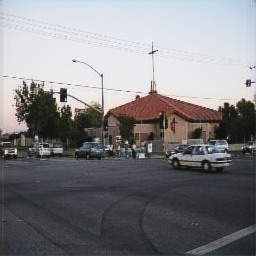

In [15]:
generate_image("000000487217")